In [ ]:
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Dropout, MaxPooling1D, Flatten
import pandas as pd
from sklearn.preprocessing import KBinsDiscretizer
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [ ]:
#데이터 불러오기(경로)
os.chdir('/content/drive/MyDrive/Colab Notebooks/DACON BitcoinTrader Season3')
train_x_df = pd.read_csv('./data/train_x_df.csv')
train_y_df = pd.read_csv('./data/train_y_df.csv')
test_x_df = pd.read_csv('./data/test_x_df.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def df2d_to_array3d(df_2d):

    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d

def kbindiscreter(input_array,feature_num, n_bins):
  kb = KBinsDiscretizer(n_bins=n_bins, strategy='uniform', encode='ordinal')
  processed_data = np.zeros((input_array.shape[0], input_array.shape[1], 1))
  for i in range(input_array.shape[0]):
    # coin_index_export args : (input_array, coin_num)
    processing_array = input_array[i,:,int(feature_num)]
    #globals()['outliery_array{}'.format(i)] = train_y_array[outlier[i],:,1]
    kb.fit(processing_array.reshape(input_array.shape[1],1))
    processed_fit = kb.transform(processing_array.reshape(input_array.shape[1],1))
    #globals()['outliery_fit{}'.format(i)] = kb.transform(globals()['outliery_array{}'.format(i)].reshape(120,1))
    processed_data[i,:,:] = processed_fit
  return processed_data

def time_split(input_array, split_size = 6):

    # origin size define
    index_size = input_array.shape[0]
    origin_time_size = input_array.shape[1]
    variable_size = input_array.shape[2]

    # new array size define
    new_time_size = int(origin_time_size/split_size) # 1380 / 6
    new_array = np.zeros((index_size, new_time_size, variable_size))

    for idx in range(index_size):
        for time_idx in range(new_time_size):
            

            first_time_idx = time_idx * split_size
            last_time_idx = ((time_idx+1) * split_size) -1

           # new_array[idx, time_idx, 0] = input_array[idx, first_time_idx, 0] #coin_num
            new_array[idx, time_idx, 0] = input_array[idx, first_time_idx, 0] #open

    return new_array
  
def make_vwap_and_diff(df):

    # 1) VAWP 계산

    # 일반적인 VWAP 공식에서 volume을 그대로 사용하지만, 여러번의 시도를 통해 tb_base_av 와 volume을 더했을 때 가장 좋은 volume이 나온다고 판단하여서 사용하였습니다.
    df["volume_tb_base_av"] = df["tb_base_av"] + df["volume"]                                                            
  #____________________________________________________________________________________________  
    # open하나만을 사용하기 보다는 open(시가), high(고가), low(저가) 3개의 평균을 price로 사용하였습니다. ------------------------------>이부분을 아래와 같이 수정
    #df['volume_price'] = ((df['open'] + df['high'] + df['low']) / 3) * df['volume_tb_base_av']
 
    # (open + close)/2 = price 로 사용할 것임.  그이유는 high와 low를 포함하는 값은 오차의 범위가 너무 커짐
    # df['volume_price'] = ((df['open'] + df['close']) / 2) * df['volume_tb_base_av']
  #  ------------------------------------------------------------------------------------------
# 2차 수정 2021.07.05 22:05 아래와 같이 수정할 것임 , 마지막 나눠주는 분모도 3으로 바꿈
    df['volume_price'] = ((((df['high'] + df['low'])/2) +  df['open'] + df['close']) / 3) * df['volume_tb_base_av']
    #  ------------------------------------------------------------------------------------------

    # price와 volume의 곱의 합을 구해줍니다.
    df['volume_price_sum'] = df.groupby(['sample_id'])['volume_price'].apply(lambda x: x.cumsum())

    # volume의 합을 구해줍니다.
    df['volume_sum'] = df.groupby(['sample_id'])['volume_tb_base_av'].apply(lambda x: x.cumsum())

    # 2 변수의 나눗셈을 통해 vwap을 계산해줍니다.
    df['vwap'] = df['volume_price_sum'] / df['volume_sum']


    # 2) diff 계산
    # 매도수익이 open을 통해 이루어진다고 알려져있기 때문에 open에서 vwap을 뺀 값을 diff로 사용했습니다.          
    df["diff"] = df["open"] - df["vwap"]


    return df

In [ ]:
# 데이터 프레임에서 sample_id 에 따른 open을 반환하는 함수입니다.
def get_open(df,sample_id):
    
    return df[df["sample_id"] == sample_id]['open'].values

# 데이터 프레임에서 sample_id 에 따른 VWAP을 반환하는 함수입니다.
def get_vwap(df,sample_id):
    
    return df[df["sample_id"] == sample_id]['vwap'].values
    
# 데이터 프레임에서 sample_id 에 따른 diff 반환하는 함수입니다.
def get_diff(df,sample_id):
    
    return df[df["sample_id"] == sample_id]['diff'].values

# 데이터 프레임에서 sample_id 에 따른 rsi 반환하는 함수입니다.
def get_rsi(df,sample_id):
    
    return df[df["sample_id"] == sample_id]['rsi'].values

# 데이터 프레임에서 sample_id 에 따른 col_name 값을 반환하는 함수입니다.
def get_series(df,sample_id, col_name):
    
    return df[df["sample_id"] == sample_id][col_name].values

In [ ]:
def make_rsi(df, period=9):
#  ------------------------------------------------------------------------------------------

    # 전일 대비 상승분을 계산해줍니다. - 상승분이 0보다 크면 상승분을 넣고, 0보다 작거나 같으면 0을 넣어줍니다.
    df["U"] = np.where(df.groupby(["sample_id"])["open"].diff(1) > 0, df.groupby(["sample_id"])["open"].diff(1), 0)

    # 전일 대비 하락분을 계산해줍니다. - 하락분이 0보다 작으면 하락분 * -1을 넣고, 0보다 크거나 같으면 0을 넣어줍니다.
    df["D"] = np.where(df.groupby(["sample_id"])["open"].diff(1) < 0, df.groupby(["sample_id"])["open"].diff(1) *(-1), 0)


    # 전일 대비 상승분의 평균을 계산해줍니다.
    ud_df = pd.DataFrame()
    ud_df["sample_id"] = df["sample_id"]
    ud_df["U"] = df["U"]
    ud_df["D"] = df["D"]

    # 상승분의 9일 평균을 구해줍니다.
    df["AU"] = ud_df.groupby(["sample_id"])["U"].rolling( window=period, min_periods=period ).mean().reset_index()["U"]
    # 하락분의 9일 평균을 구해줍니다.
    df["AD"] = ud_df.groupby(["sample_id"])["D"].rolling( window=period, min_periods=period ).mean().reset_index()["D"]


    # AU / (AU + AD) 의 백분율을 RSI 로 계산해줍니다.
    RSI = df["AU"] / (df["AU"] + df["AD"]) * 100
    
    df["rsi"] = RSI
    
    return df

In [ ]:
train_x_df["is_x"] = 1
train_y_df["is_x"] = 0
train_x_y = [train_x_df, train_y_df]
train_list = [x.set_index('sample_id') for x in train_x_y]

train_z = pd.concat(train_list, axis=0).rename_axis('sample_id').reset_index()

In [ ]:
TRAIN_SAMPLE_ID_LIST = train_x_df["sample_id"].unique().tolist()
TEST_SAMPLE_ID_LIST = test_x_df["sample_id"].unique().tolist()

In [ ]:
test_x = make_vwap_and_diff(test_x_df)
train_z = make_vwap_and_diff(train_z)

In [ ]:
test_x = make_rsi(test_x, 25)
train_z = make_rsi(train_z, 25)

In [ ]:
train_x = train_z[train_z["is_x"] == 1]
train_y = train_z[train_z["is_x"] == 0]

split_drop_cols = ["is_x"]

train_x = train_x.drop(columns=split_drop_cols, axis=1)
train_y = train_y.drop(columns=split_drop_cols, axis=1)

In [ ]:
#train 값 보기
train_x

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av,volume_tb_base_av,volume_price,volume_price_sum,volume_sum,vwap,diff,U,D,AU,AD,rsi
0,0,0,0,0.993147,0.993546,0.992857,0.992966,1379.478027,3778.584961,11.240029,329.655548,903.091614,1709.133575,1697.349022,1697.349022,1709.133575,0.993105,0.000042,0.000000,0.000000,NaN,NaN,NaN
1,0,1,0,0.993256,0.993546,0.992712,0.992712,3438.807373,9419.426758,11.602611,1363.999268,3737.512695,4802.806641,4769.342681,6466.691702,6511.940216,0.993051,0.000205,0.000109,0.000000,NaN,NaN,NaN
2,0,2,0,0.992748,0.994815,0.992458,0.994815,3714.949463,10173.972656,19.579407,1222.802856,3350.688721,4937.752319,4906.809431,11373.501133,11449.692535,0.993346,-0.000597,0.000000,0.000508,NaN,NaN,NaN
3,0,3,0,0.994779,0.995286,0.994090,0.994996,2430.264648,6666.315430,15.591008,520.159546,1426.920776,2950.424194,2935.144393,14308.645526,14400.116730,0.993648,0.001131,0.002030,0.000000,NaN,NaN,NaN
4,0,4,0,0.994561,0.994779,0.993727,0.994779,3062.139404,8395.172852,15.228427,2166.334473,5939.279785,5228.473877,5199.879746,19508.525272,19628.590607,0.993883,0.000678,0.000000,0.000217,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10942015,7928,1375,8,0.999708,1.000073,0.999562,0.999854,1.048120,143.449982,0.401812,0.612980,83.898582,1.661099,1.660755,2282.603688,2310.173287,0.988066,0.011642,0.000000,0.000000,0.000353,0.000305,53.594639
10942016,7928,1376,8,0.999708,1.000000,0.999489,0.999781,0.706883,96.735909,0.409117,0.501885,68.683640,1.208767,1.208458,2283.812146,2311.382054,0.988072,0.011636,0.000000,0.000000,0.000353,0.000310,53.246669
10942017,7928,1377,8,0.999708,1.000000,0.999489,0.999781,1.643578,224.917908,0.620982,0.788707,107.937714,2.432286,2.431664,2286.243809,2313.814340,0.988084,0.011623,0.000000,0.000000,0.000353,0.000409,46.327853
10942018,7928,1378,8,0.999708,1.000146,0.999489,1.000000,1.204417,164.840317,0.752484,0.869763,119.042564,2.074181,2.073852,2288.317662,2315.888521,0.988095,0.011613,0.000000,0.000000,0.000353,0.000383,47.953482


In [ ]:
#결측치 확인
train_x.isnull().sum()

sample_id                 0
time                      0
coin_index                0
open                      0
high                      0
low                       0
close                     0
volume                    0
quote_av                  0
trades                    0
tb_base_av                0
tb_quote_av               0
volume_tb_base_av         0
volume_price              0
volume_price_sum          0
volume_sum                0
vwap                   2125
diff                   2125
U                         0
D                         0
AU                   175080
AD                   175080
rsi                  175175
dtype: int64

In [ ]:
# #excel로 뽑아서 어디서 nan(결측치)이 생기는지 확인
# val_coin_dataframe = pd.DataFrame(train_x['sample_id'][train_x['diff'].isnull()])
# val_coin_dataframe.to_csv('nan_idx.csv', index=False)

In [ ]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10942020 entries, 0 to 10942019
Data columns (total 23 columns):
 #   Column             Dtype  
---  ------             -----  
 0   sample_id          int64  
 1   time               int64  
 2   coin_index         int64  
 3   open               float64
 4   high               float64
 5   low                float64
 6   close              float64
 7   volume             float64
 8   quote_av           float64
 9   trades             float64
 10  tb_base_av         float64
 11  tb_quote_av        float64
 12  volume_tb_base_av  float64
 13  volume_price       float64
 14  volume_price_sum   float64
 15  volume_sum         float64
 16  vwap               float64
 17  diff               float64
 18  U                  float64
 19  D                  float64
 20  AU                 float64
 21  AD                 float64
 22  rsi                float64
dtypes: float64(20), int64(3)
memory usage: 2.0 GB


In [ ]:
train_x_array = df2d_to_array3d(train_x)
train_y_array = df2d_to_array3d(train_y)
# test_x_array = df2d_to_array3d(test_x)

In [ ]:
#vwap = 15번쨰 feature임을 확인
train_x_array[:,:,15]

array([[ 4.22994296e-05,  2.04518498e-04, -5.97170641e-04, ...,
        -1.54494978e-02, -1.90106731e-02, -1.61404340e-02],
       [-3.27308973e-04,  3.81872433e-04,  5.62377223e-04, ...,
        -2.01570676e-03, -3.31983022e-04, -7.05852902e-04],
       [ 1.29282475e-04,  1.56387830e-04, -6.61072555e-04, ...,
        -8.76477955e-04, -7.11466804e-04, -5.71547853e-04],
       ...,
       [-1.35787328e-03,  1.31438614e-03,  6.90041341e-05, ...,
        -1.63470011e-02, -1.50315564e-02, -1.45308435e-02],
       [ 1.66098277e-04, -1.72540174e-04,  5.71580150e-04, ...,
        -1.82879459e-02, -1.87233502e-02, -1.76463765e-02],
       [-1.21792157e-05, -2.24926302e-04,  7.18633960e-04, ...,
         1.16233179e-02,  1.16127877e-02,  1.18985289e-02]])

In [ ]:
# X_train, y_train sampling(X의 nan값 제거 위해 90분 이후 대이터부터 사용)
X_train =train_x_array[:,90:,15].reshape(-1,1290,1)
y_train =train_y_array[:,:,15].reshape(-1,120,1)

In [ ]:
#kbind된 X_train 사용 시
Xbin_train = kbindiscreter(X_train, 0, 100)

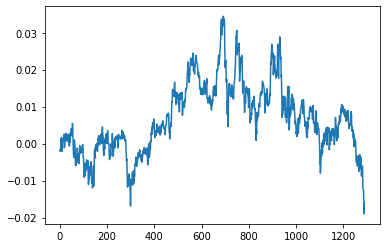

In [ ]:
plt.plot(X_train[0])

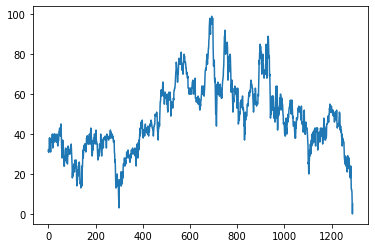

In [ ]:
plt.plot(Xbin_train[0])

In [ ]:
#y_train에서 6분봉 데이터 sampling
split_y_array = time_split(y_train,split_size=12)

In [ ]:
split_y_array.shape

(7929, 10, 1)

In [ ]:
#kbind된 X_train 사용 시
split_y_array = kbindiscreter(split_y_array, 0, 10)

In [ ]:
split_y_array.shape

(7929, 10, 1)

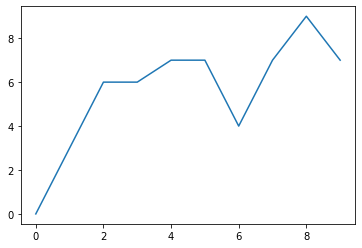

In [ ]:
plt.plot(split_y_array[0])

In [ ]:
#one-hot encoding으로 가장 높은 y 값만 1인 데이터로 만들기
y_traina = np.zeros((X_train.shape[0], 10))
for i in range(X_train.shape[0]):
  for j in range(10):
    if np.argmax(split_y_array[i,:,0]) ==j:
      y_traina[i,j] = 1

In [ ]:
#input shape 확인
print(X_train.shape)
print(y_traina.shape)

(7929, 1290, 1)
(7929, 10)


In [ ]:
X_train.shape[2]

1

In [ ]:
#modeling
model = Sequential()
model.add(Conv1D(64,10, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Conv1D(32,5, activation='relu'))
model.add(MaxPooling1D(4))
model.add(Conv1D(32,4, activation='relu'))
model.add(Conv1D(16,4, activation='relu'))
model.add(MaxPooling1D(4))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(256,activation='relu'))
model.add(Dense(units=10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train,y_traina,epochs=15,validation_split=0.1,shuffle=True)

Epoch 1/15
223/223 [==============================] - 4s 14ms/step - loss: 2.2246 - accuracy: 0.2414 - val_loss: 2.2038 - val_accuracy: 0.2598
Epoch 2/15
223/223 [==============================] - 3s 12ms/step - loss: 2.2071 - accuracy: 0.2460 - val_loss: 2.2037 - val_accuracy: 0.2598
Epoch 3/15
223/223 [==============================] - 3s 11ms/step - loss: 2.2017 - accuracy: 0.2536 - val_loss: 2.2080 - val_accuracy: 0.2598
Epoch 4/15
223/223 [==============================] - 3s 12ms/step - loss: 2.1984 - accuracy: 0.2523 - val_loss: 2.2042 - val_accuracy: 0.2598
Epoch 5/15
223/223 [==============================] - 3s 12ms/step - loss: 2.1888 - accuracy: 0.2577 - val_loss: 2.2090 - val_accuracy: 0.2598
Epoch 6/15
223/223 [==============================] - 3s 12ms/step - loss: 2.2008 - accuracy: 0.2422 - val_loss: 2.1977 - val_accuracy: 0.2598
Epoch 7/15
223/223 [==============================] - 3s 12ms/step - loss: 2.1963 - accuracy: 0.2489 - val_loss: 2.2072 - val_accuracy: 0.2560

In [ ]:
#plotting 해볼 index 선택 및 결과 뽑기(k ~ k+len)
k=7500
len = 100
n_past=1290
val_result = model.predict(X_train[k:k+len,:,:].reshape(len,n_past,1))

1


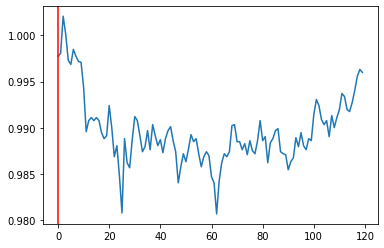

2


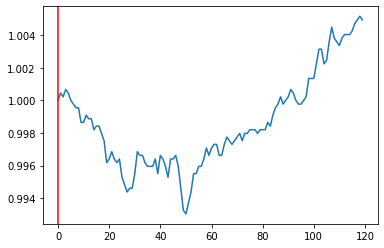

3


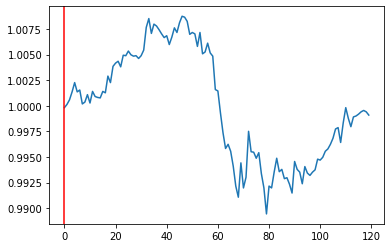

4


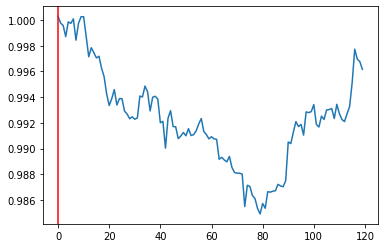

5


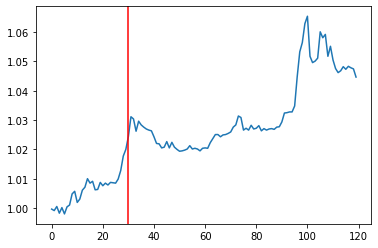

6


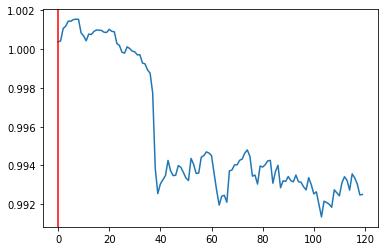

7


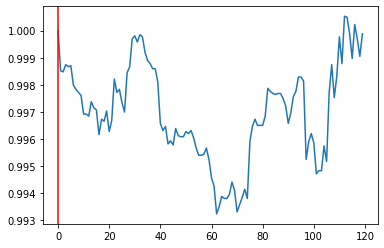

8


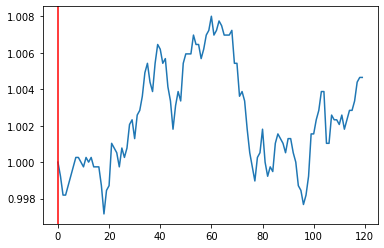

9


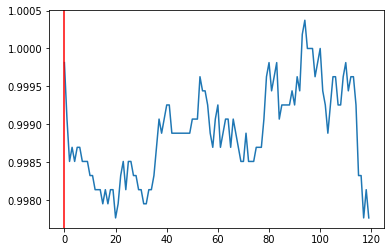

10


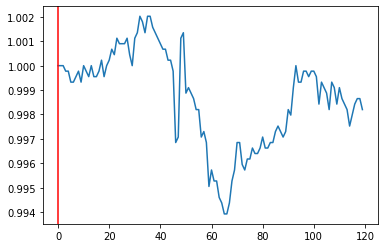

11


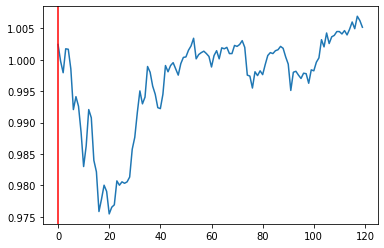

12


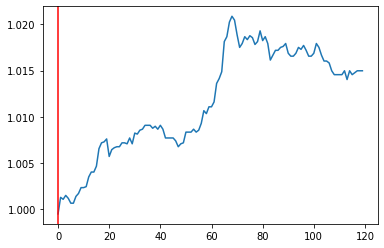

13


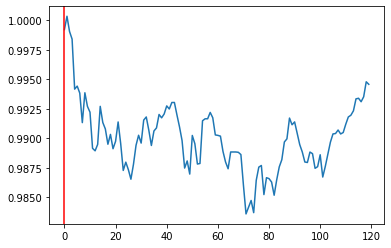

14


Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f801fc68dd0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 
Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f801fc68dd0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


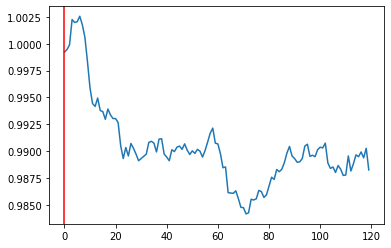

15


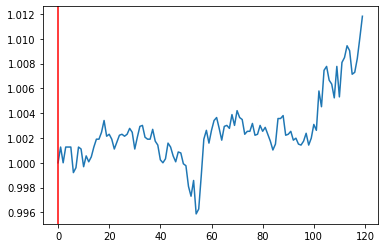

16


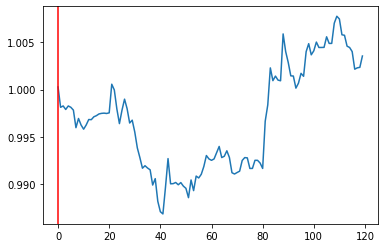

17


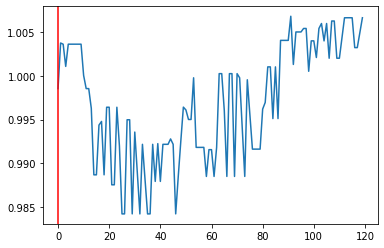

18


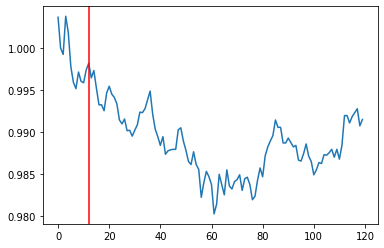

19


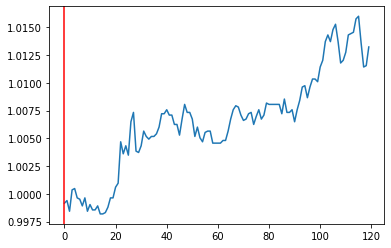

20


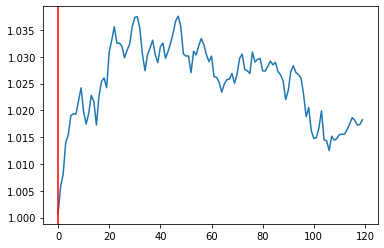

21


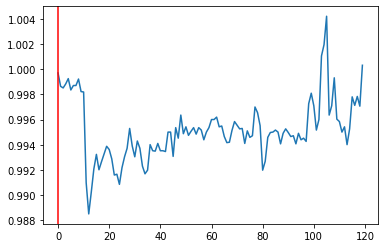

22


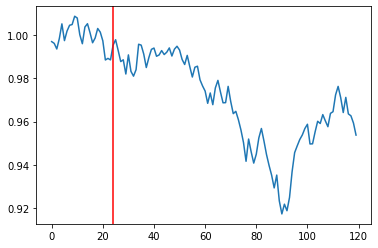

23


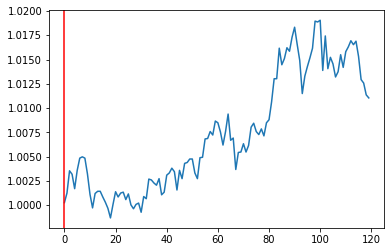

24


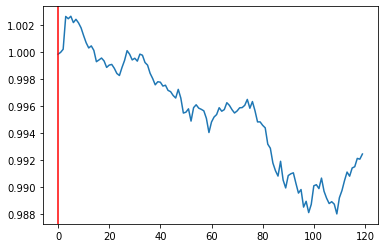

25


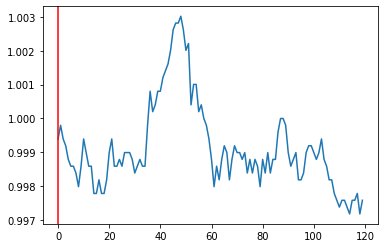

26


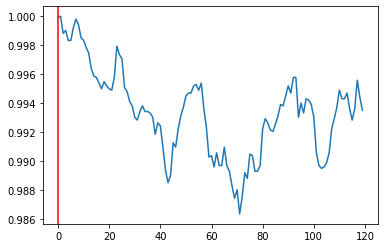

27


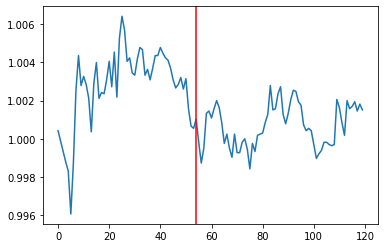

28


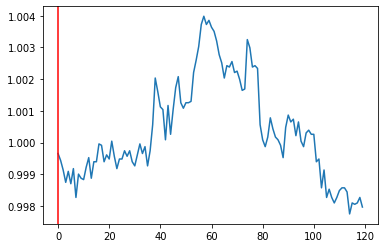

29


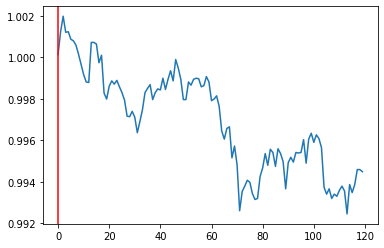

30


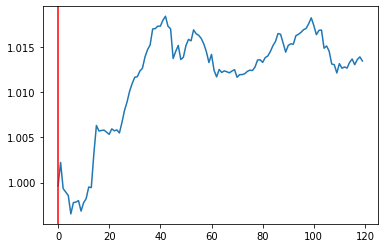

31


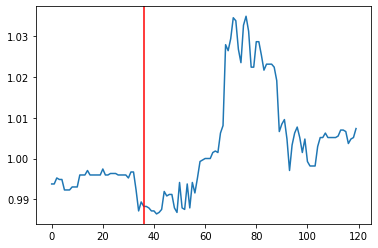

32


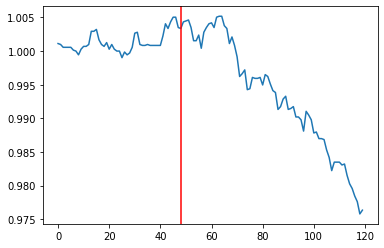

33


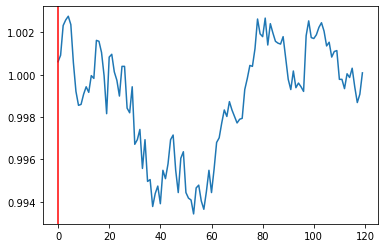

34


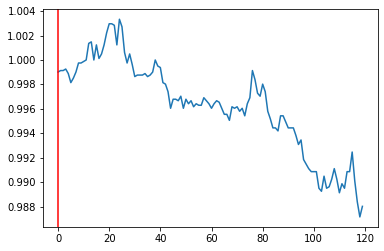

35


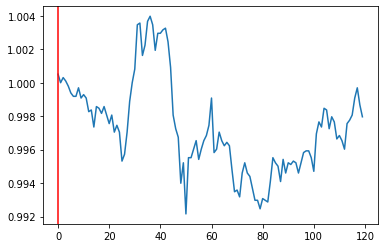

36


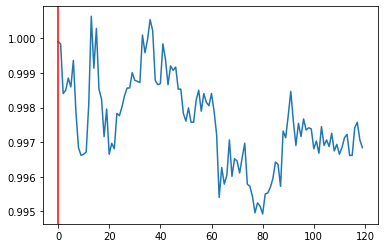

37


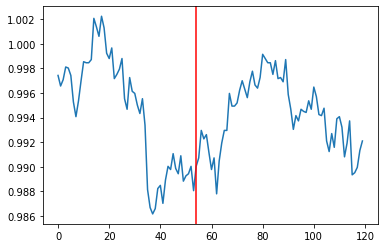

38


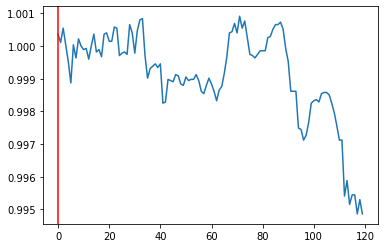

39


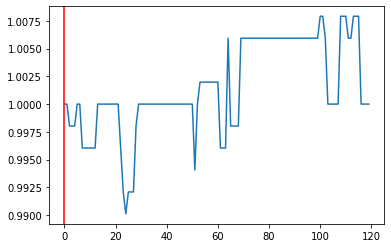

40


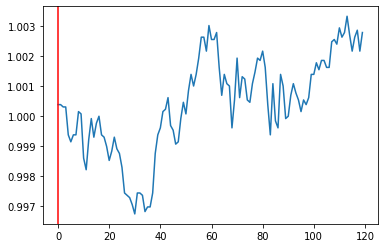

41


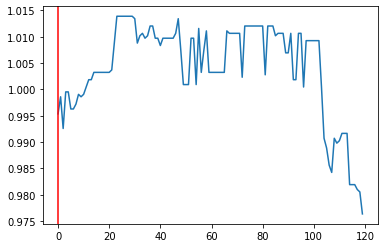

42


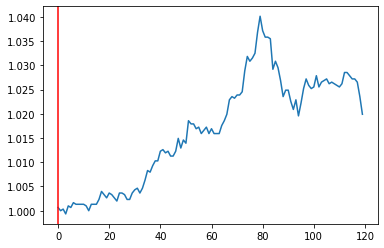

43


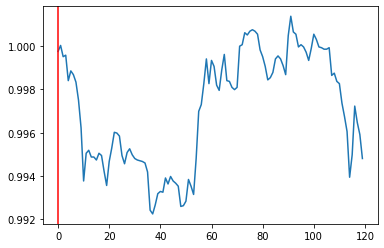

44


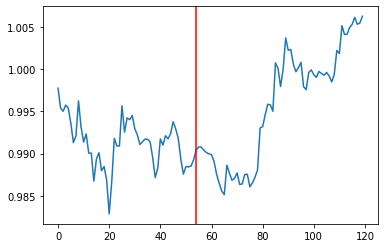

45


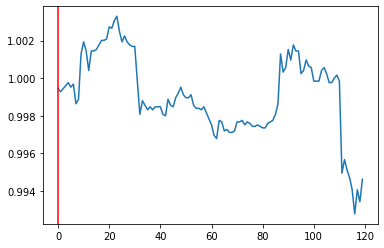

46


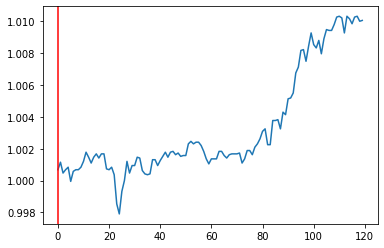

47


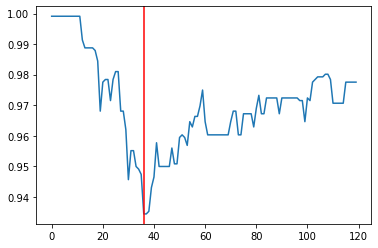

48


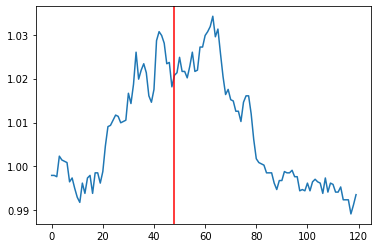

49


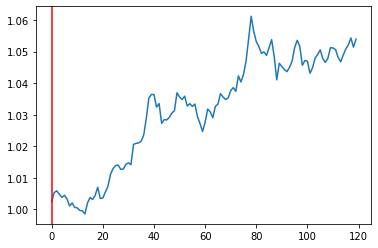

50


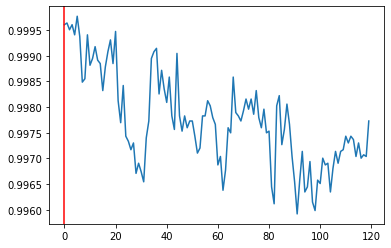

51


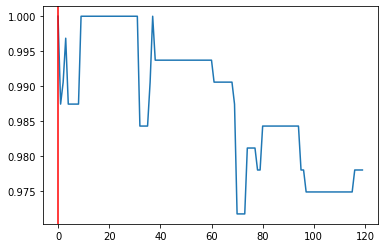

52


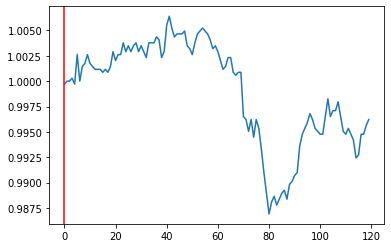

53


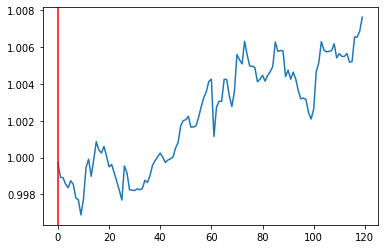

54


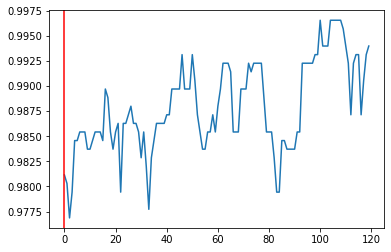

55


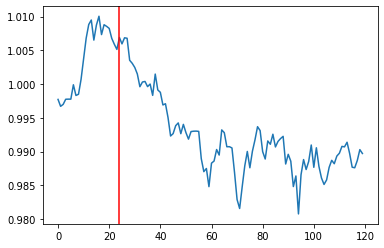

56


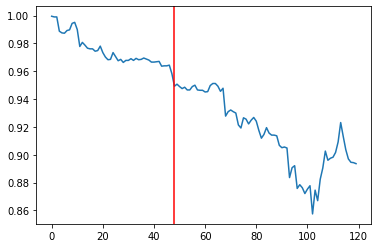

57


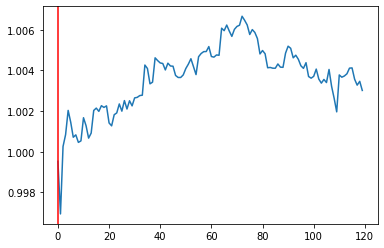

58


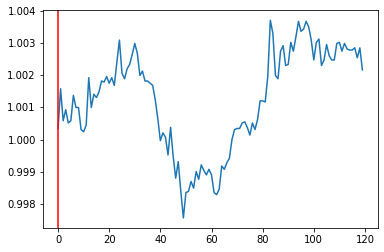

59


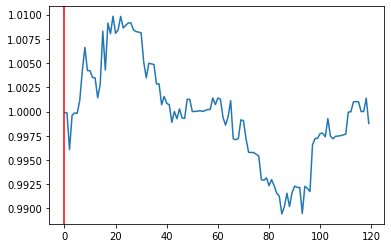

60


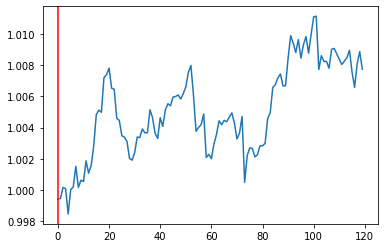

61


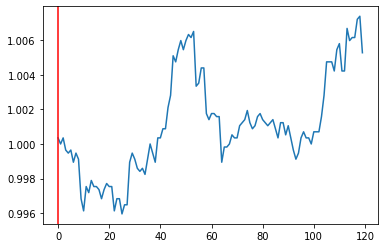

62


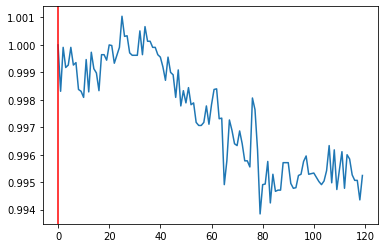

63


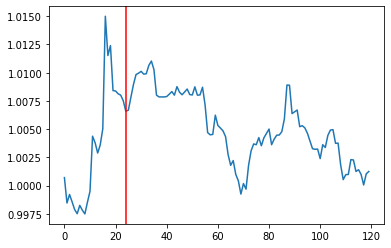

64


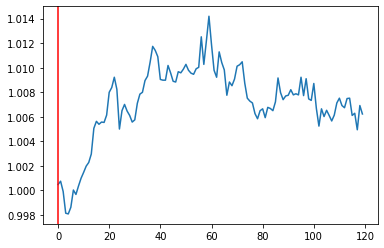

65


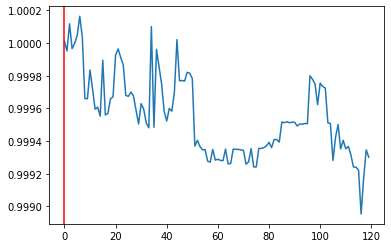

66


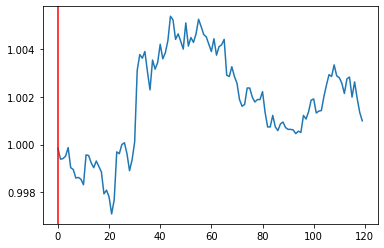

67


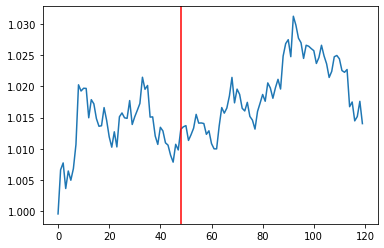

68


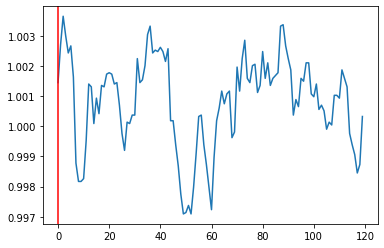

69


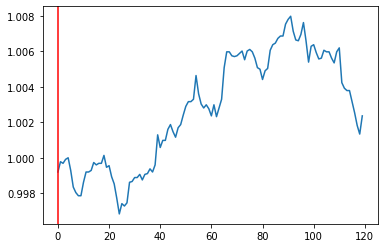

70


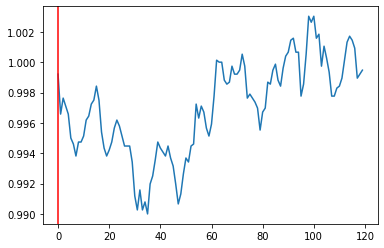

71


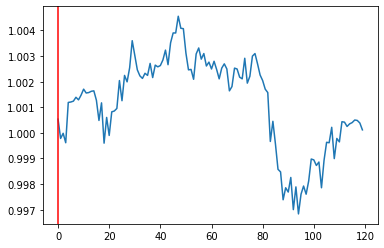

72


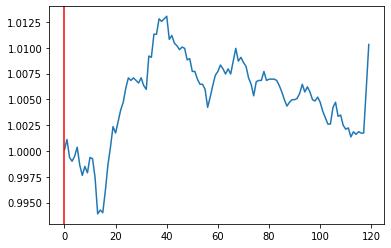

73


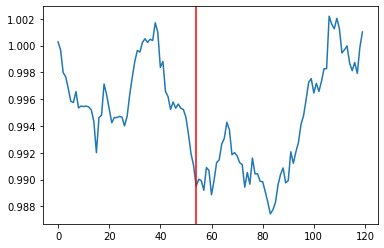

74


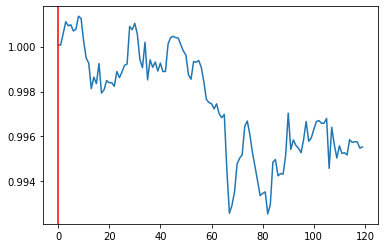

75


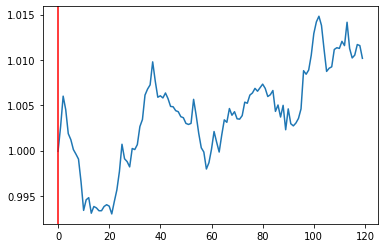

76


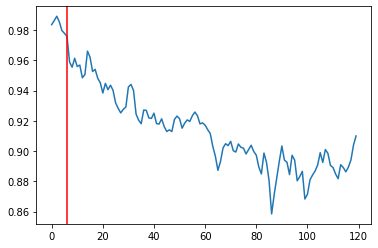

77


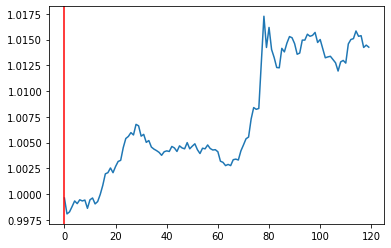

78


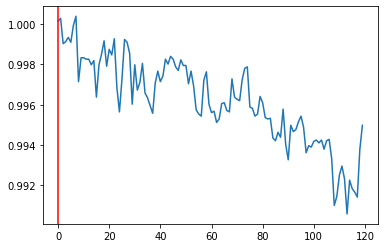

79


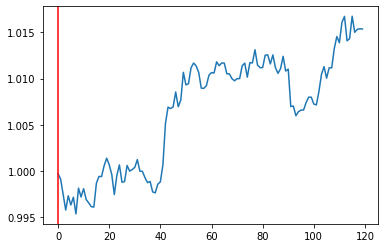

80


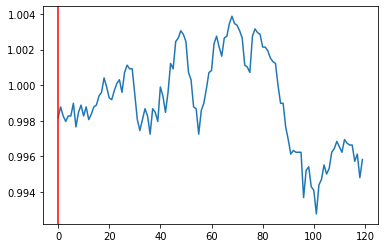

81


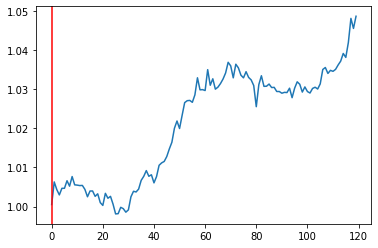

82


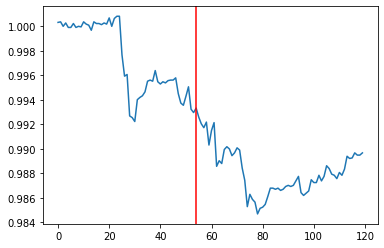

83


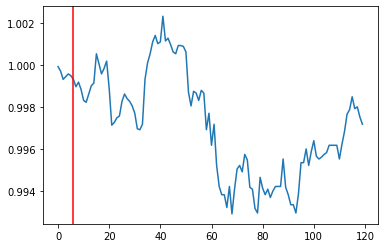

84


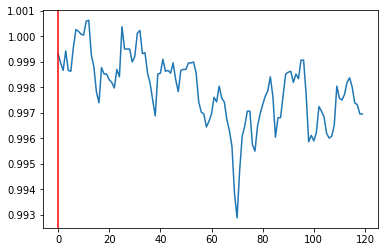

85


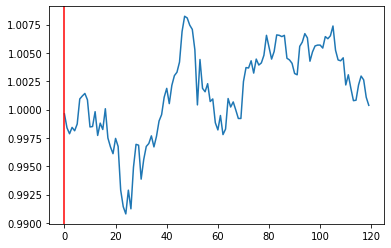

86


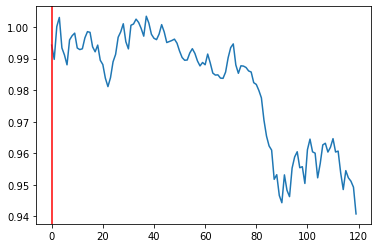

87


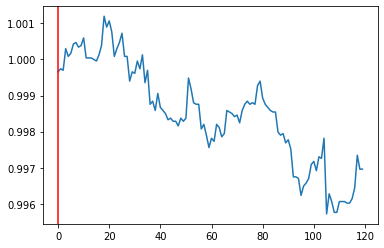

88


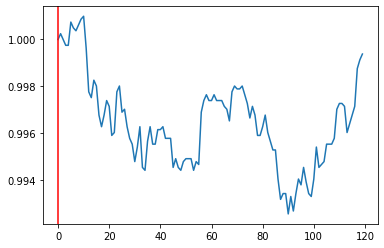

89


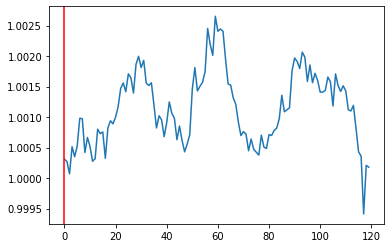

90


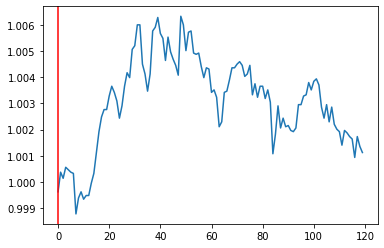

91


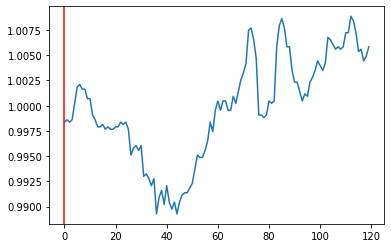

92


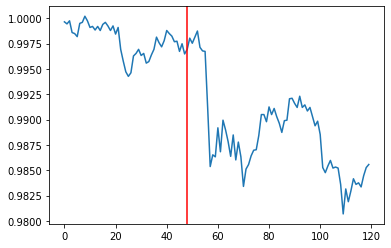

93


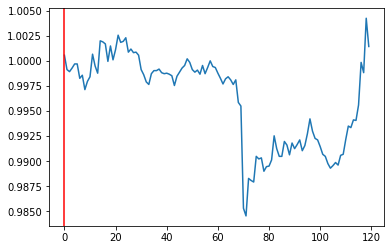

94


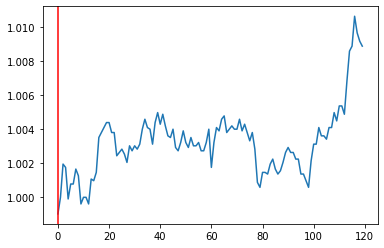

95


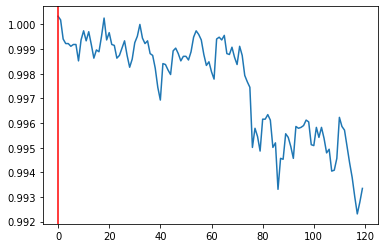

96


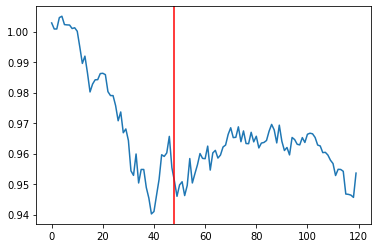

97


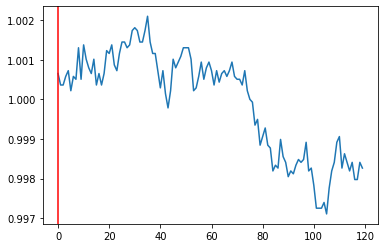

98


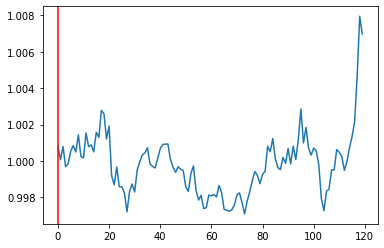

99


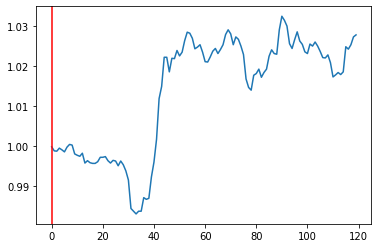

100


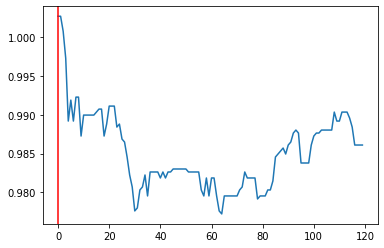

In [ ]:
#plotting 결과 보기
for i in range(100):
  print(i+1)
  # plt.ylim(0.96,1.05)
  plt.plot(train_y_array[i+k,:,1].reshape(-1),label = "true")
  # plt.plot(kk[i].reshape(-1), label = "prediction")
  plt.axvline(np.argmax(val_result[i])*6, c ='red')
  plt.show()

1


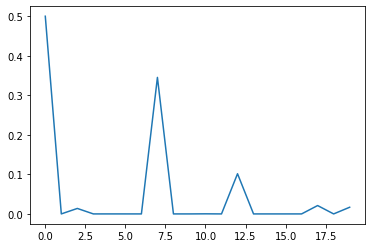

2


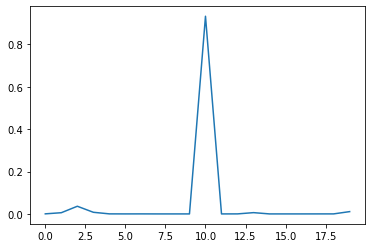

3


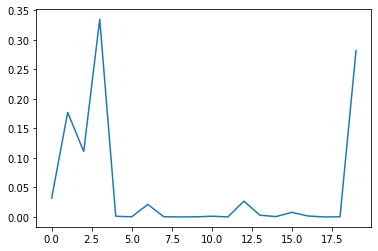

4


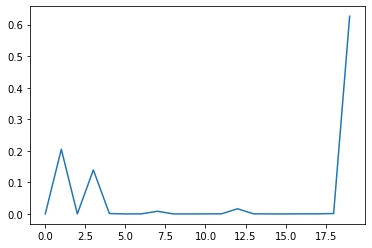

5


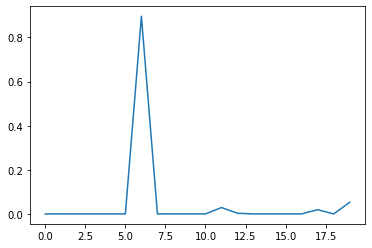

6


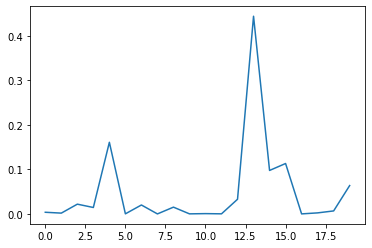

7


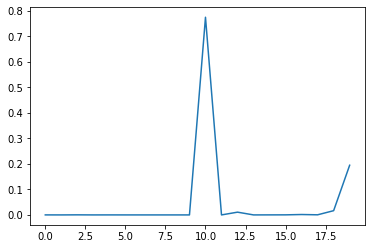

8


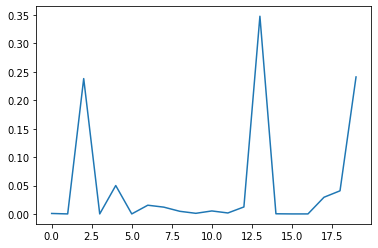

9


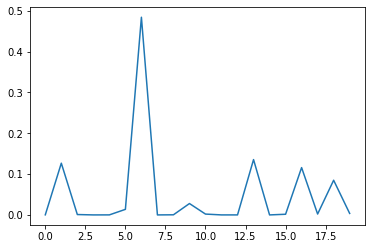

10


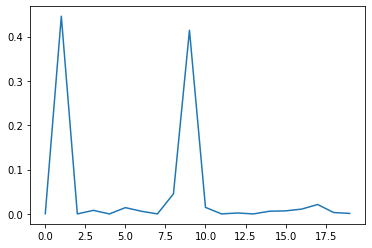

11


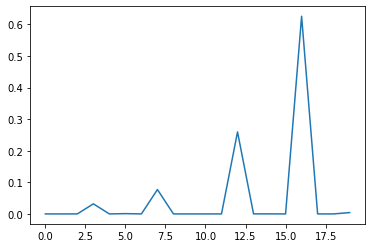

12


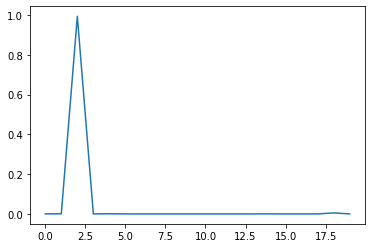

13


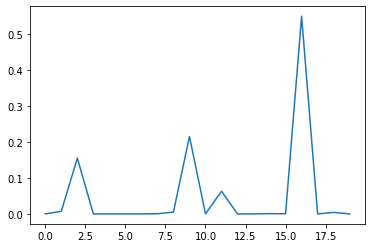

14


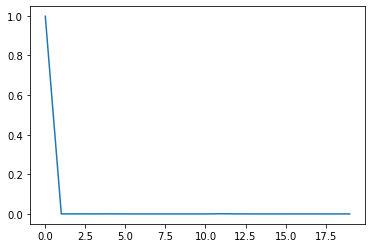

15


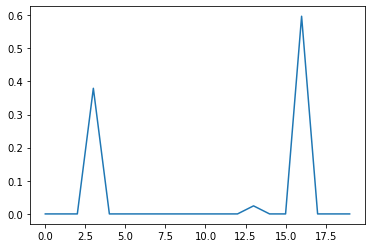

16


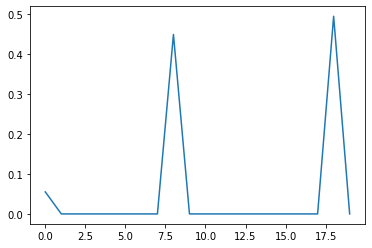

17


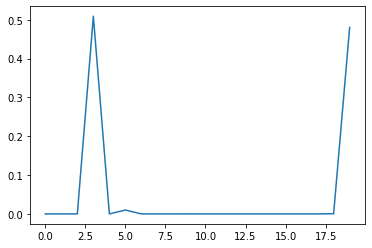

18


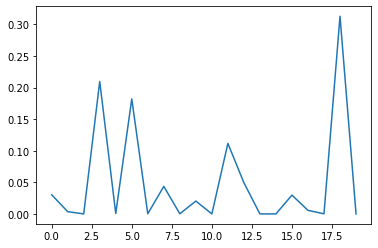

19


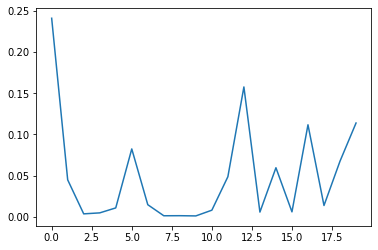

20


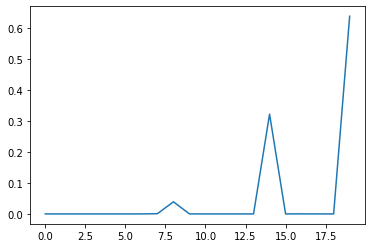

21


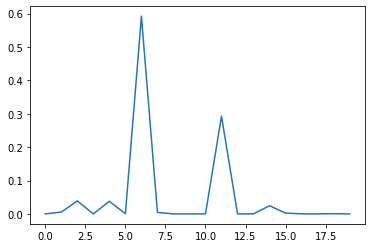

22


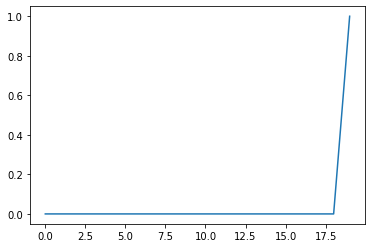

23


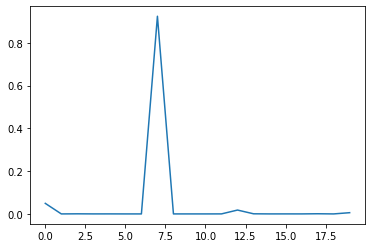

24


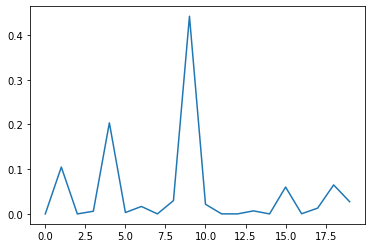

25


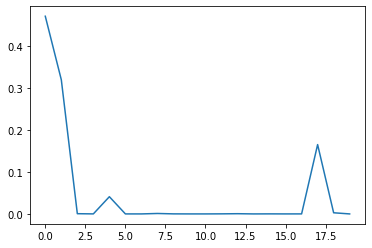

26


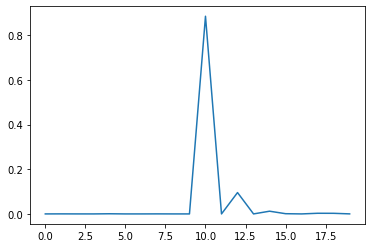

27


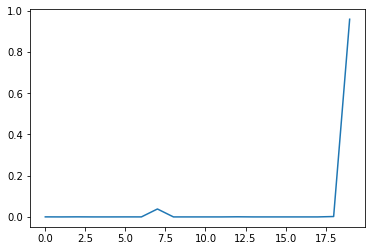

28


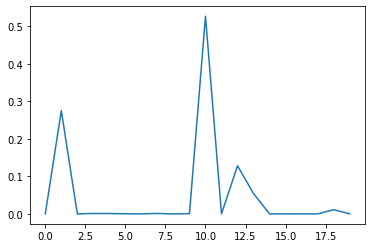

29


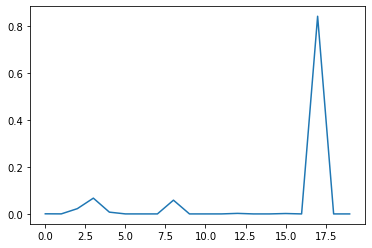

30


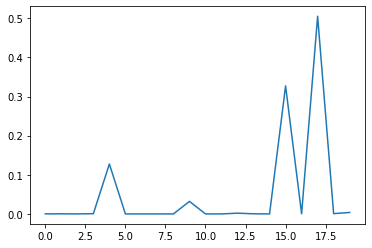

31


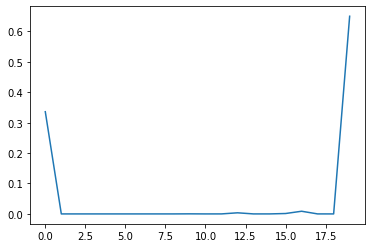

32


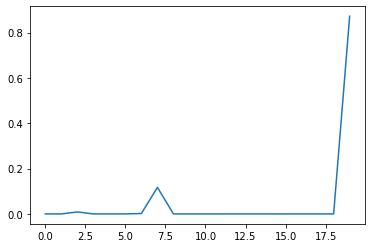

33


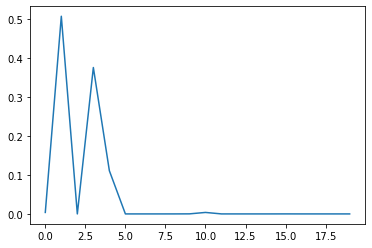

34


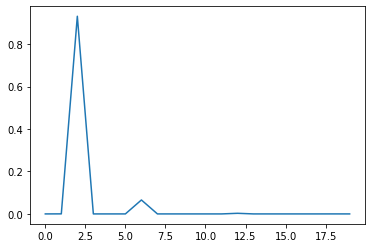

35


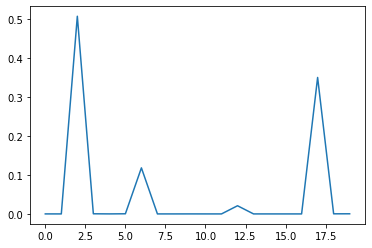

36


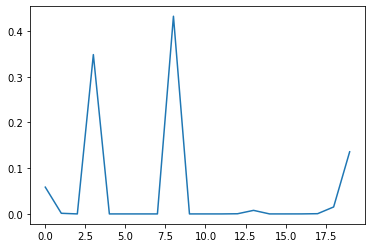

37


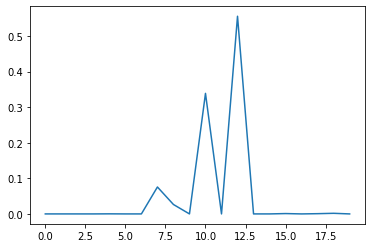

38


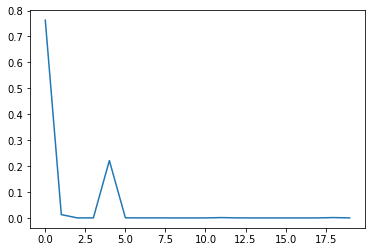

39


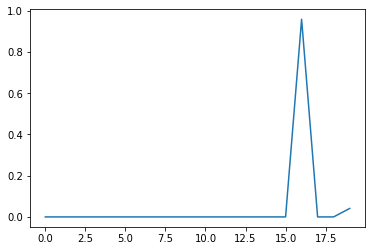

40


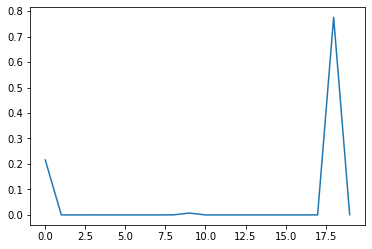

41


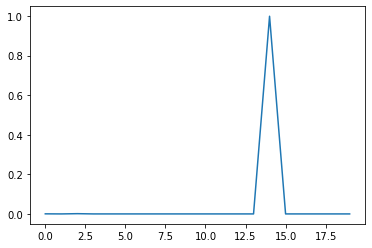

42


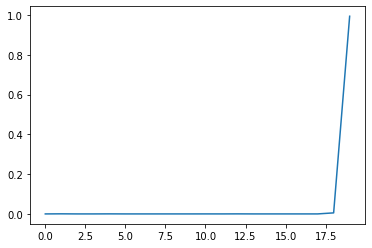

43


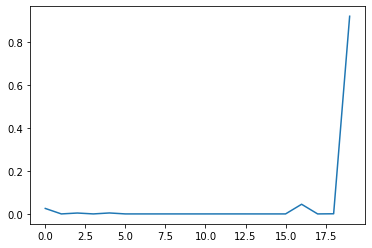

44


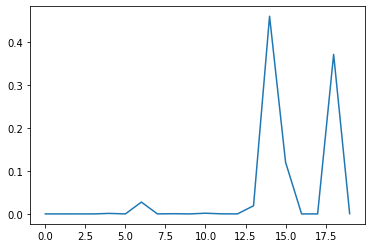

45


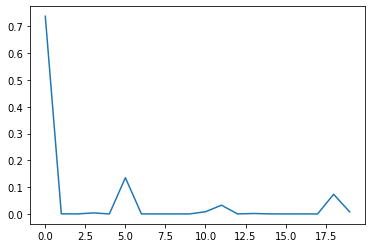

46


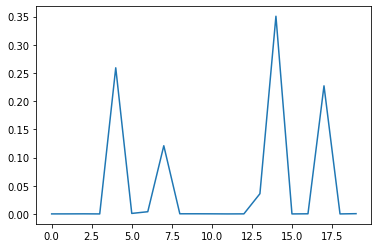

47


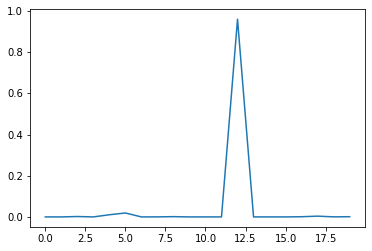

48


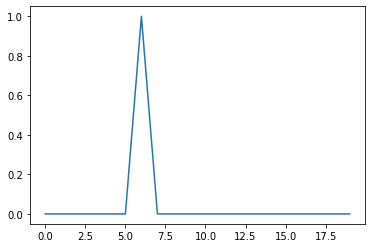

49


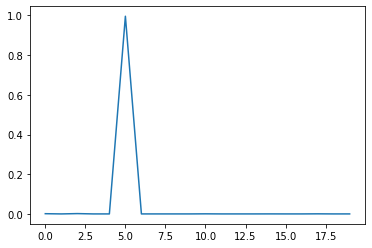

50


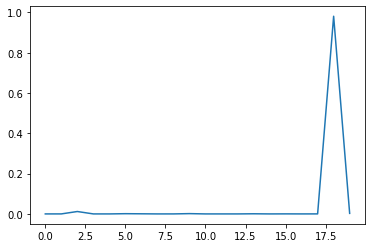

51


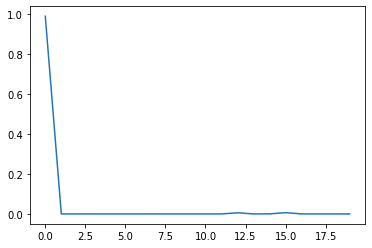

52


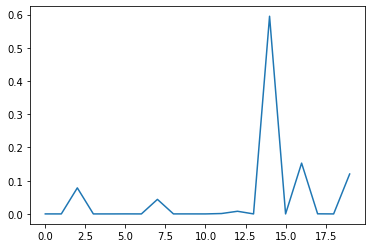

53


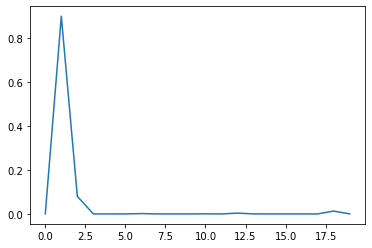

54


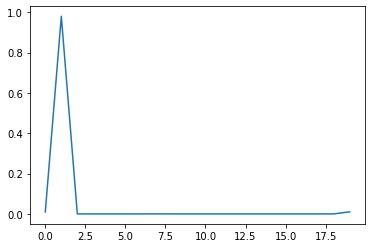

55


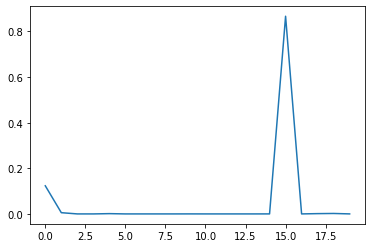

56


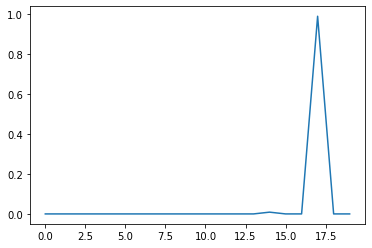

57


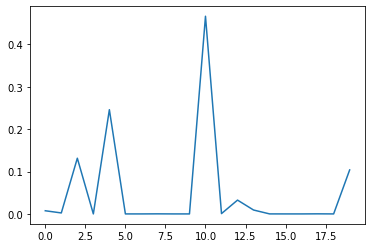

58


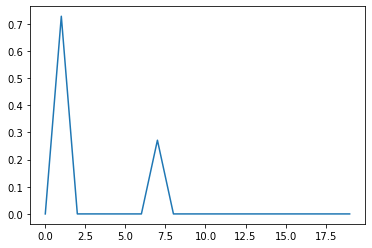

59


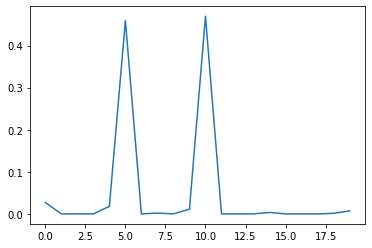

60


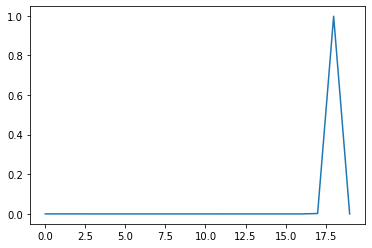

61


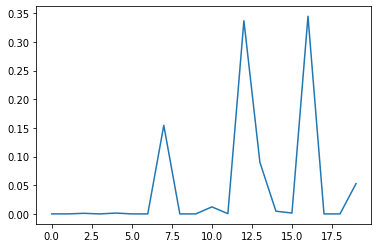

62


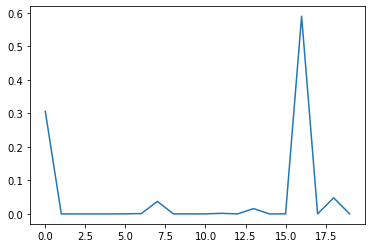

63


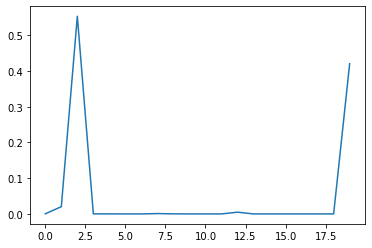

64


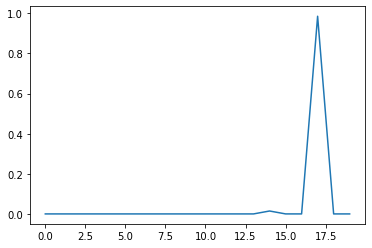

65


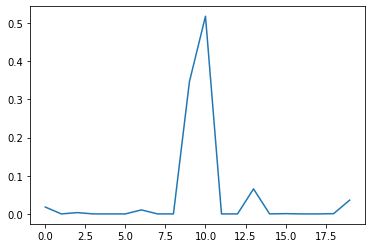

66


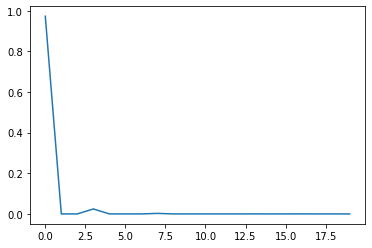

67


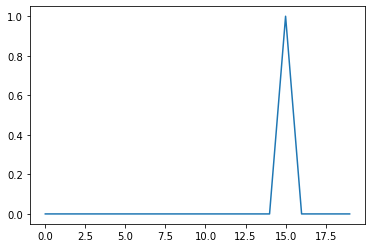

68


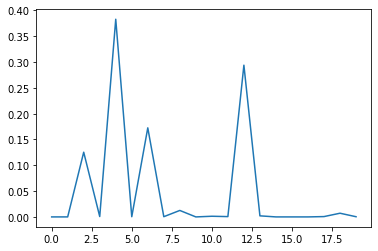

69


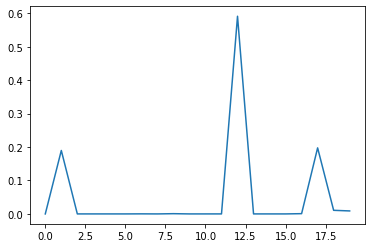

70


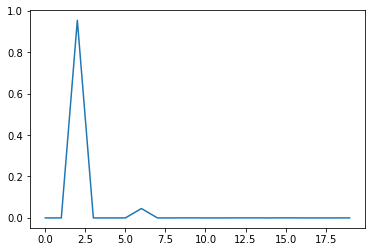

71


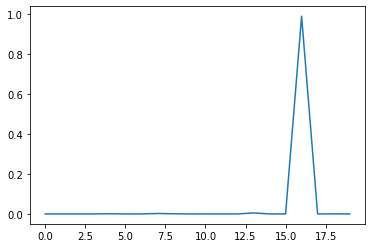

72


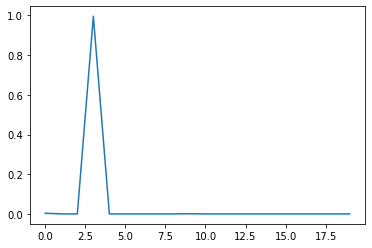

73


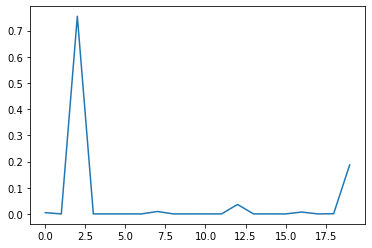

74


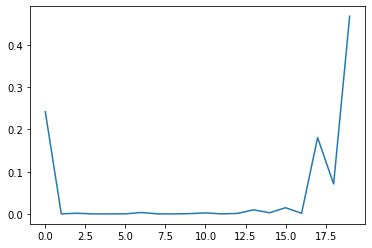

75


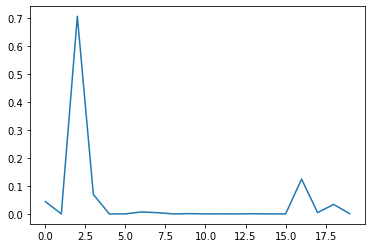

76


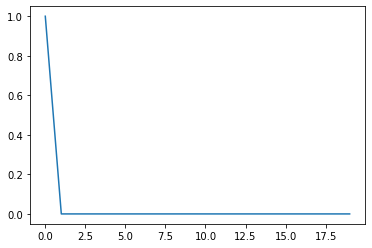

77


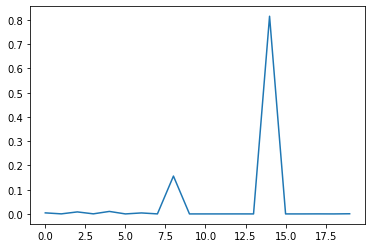

78


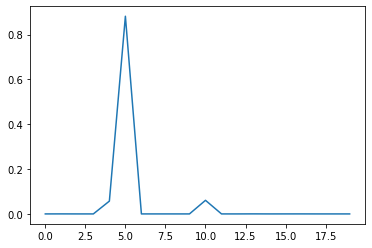

79


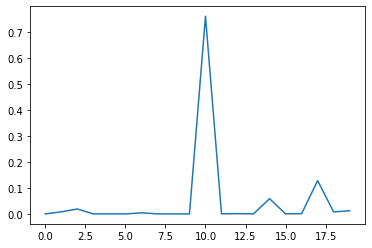

80


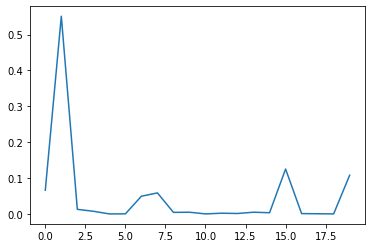

81


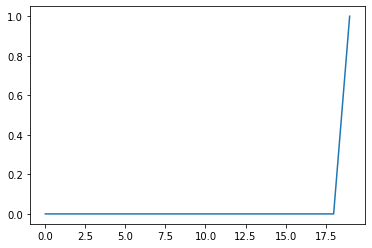

82


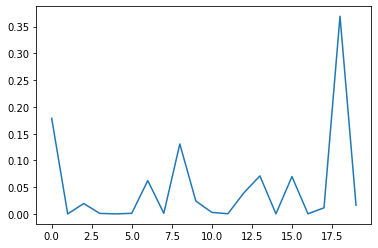

83


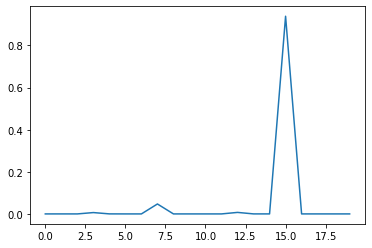

84


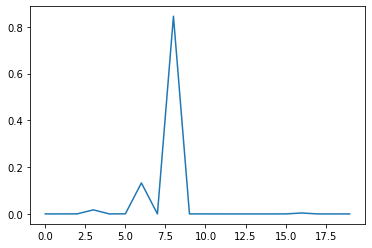

85


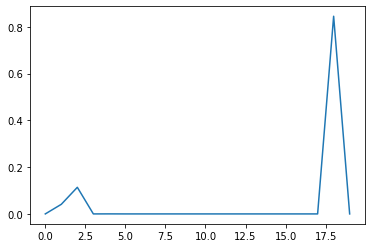

86


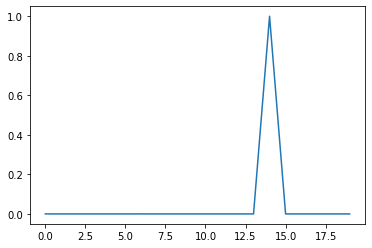

87


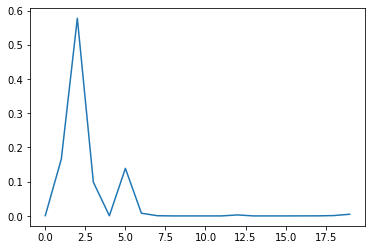

88


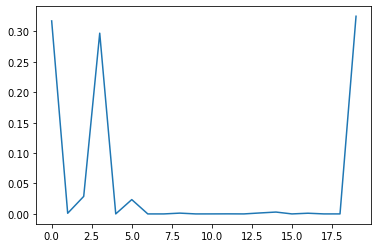

89


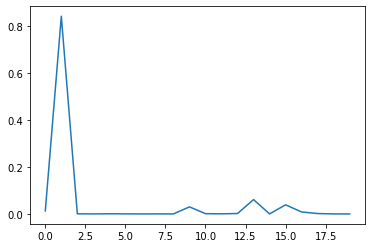

90


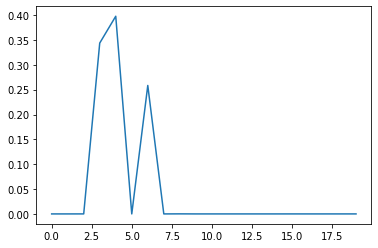

91


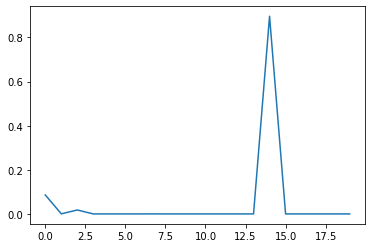

92


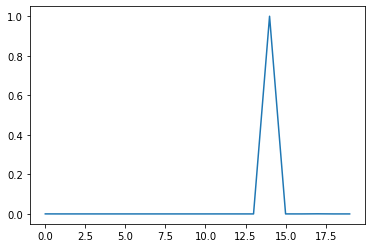

93


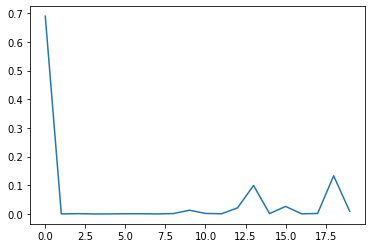

94


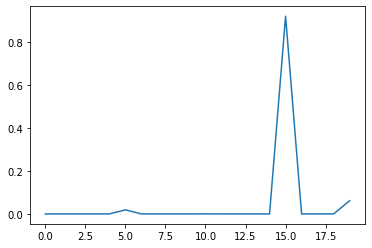

95


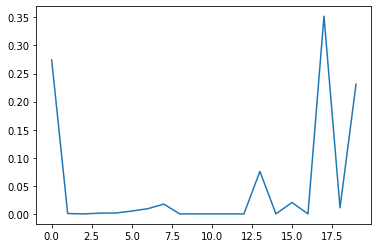

96


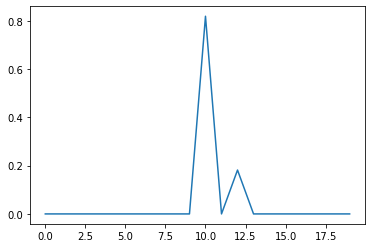

97


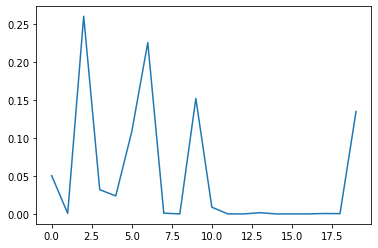

98


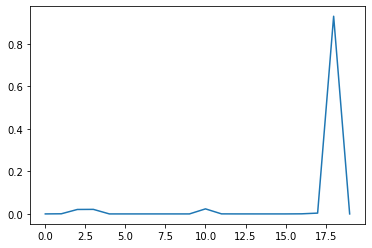

99


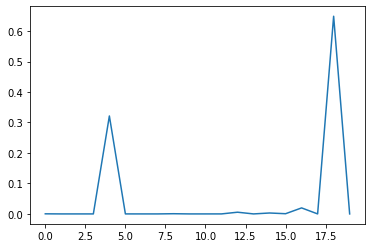

100


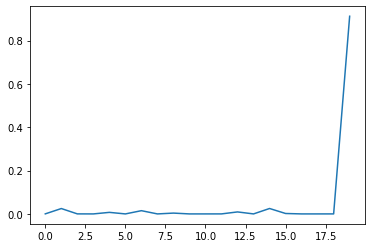

In [ ]:
#확률 plotting
for i in range(100):
  print(i+1)
  # plt.ylim(0.96,1.05)
  plt.plot(val_result[i,:].reshape(-1),label = "true")
  # plt.plot(kk[i].reshape(-1), label = "prediction")
  #plt.axvline(np.argmax(kk[i])*6, c ='red')
  plt.show()